In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [2]:
path1 = "./cifar-10-python/cifar-10-batches-py/data_batch_1"

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict 

In [4]:
data1 = unpickle(path1)

In [5]:
data1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [6]:
X_orig = data1[b'data']
y_orig = data1[b'labels']

In [7]:
X_orig.shape

(10000, 3072)

In [8]:
def do(array):
    new_array = []
    final_array = []
    lenth = (array.shape[0]//3)
    print((lenth))
    for i in range(lenth):
        new_array.append([array[i], array[lenth+i], array[2*lenth+i]])
    
    a = np.array(new_array)
    b = a.reshape(32,32,3)
    plt.imshow(b)

1024


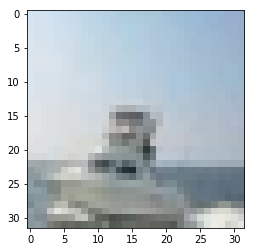

In [9]:
do(X_orig[100])

In [10]:
print(X_orig.shape, len(y_orig))

(10000, 3072) 10000


In [11]:
def init_param():
    
    W1 = tf.get_variable("W1",[50, 3072],initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1",[50,1],initializer=tf.zeros_initializer())
    
    W2 = tf.get_variable("W2",[50, 50],initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2",[50,1],initializer=tf.zeros_initializer())
    
    W3 = tf.get_variable("W3",[10, 50],initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3",[10,1],initializer=tf.zeros_initializer())
    
    param = {
        "W1" : W1,
        "b1" : b1,
        "W2" : W2,
        "b2" : b2,
        "W3" : W3,
        "b3" : b3,
    }
    
    return param

In [12]:
def placeholder(X_shape, y_shape):
    X = tf.placeholder(tf.float32, shape=(X_shape[0], None),name="X")
    y = tf.placeholder(tf.float32, shape=(y_shape[0], None),name="y")
    
    return X, y

In [13]:
def forward_prop(X, param):
    W1 = param["W1"]
    b1 = param["b1"]
    W2 = param["W2"]
    b2 = param["b2"]
    W3 = param["W3"]
    b3 = param["b3"]
    
    Z1 = tf.matmul(W1, X) + b1
    A1 = tf.nn.relu(Z1)
    Z2 = tf.matmul(W2, A1) + b2
    A2 = tf.nn.relu(Z2)
    Z3 = tf.matmul(W3, A2) + b3
    
    return Z3
    

In [14]:
def cost(predict, labels):
    
    predict = tf.transpose(predict)
    labels = tf.transpose(labels)
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = predict, labels = labels))

    return loss 

In [15]:
# def random_mini_batches(X, y, minibatchsize):
#     X=np.transpose(np.array(X))
#     y=np.transpose(np.array(y))
# #     print(X.shape, y.shape)
#     num = np.arange(X.shape[0])
#     random.shuffle(num)
#     ret_list = []
#     for i in range(int(X.shape[0]/minibatchsize)):                
#         start = i*minibatchsize
#         end = start+minibatchsize
#         a=num[start:end]
#         ret_list.append((np.transpose(X[a]), y[a]))
#     a = num[end:X.shape[0]]
#     ret_list.append((np.transpose(X[a]), np.transpose(y[a])))    
#     return ret_list

In [16]:
def random_mini_batches(X, y, minibatchsize):
    m = X.shape[1]
    num_list = np.arange(m)
    random.shuffle(num_list)
    minibatches = int(m/minibatchsize)
    ret_list = []
    for i in range(minibatches):
        start  = i*minibatchsize
        end = start + minibatchsize
        batch_list = num_list[start:end]
        ret_list.append((X[:,batch_list], y[:,batch_list]))
    final_batch_list = num_list[end:m]
    ret_list.append((X[:,final_batch_list], y[:,final_batch_list]))
    return ret_list

In [17]:
x=[[1,1], [2,2], [3,3], [4,4], [5,5]]
y=["a","b","c", "d", "e"]
# print(random_mini_batches(x,y,2))
for part in random_mini_batches(x,y,2):
    print(part)

AttributeError: 'list' object has no attribute 'shape'

In [21]:
def model(X_train, y_train, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32):
    
    tf.reset_default_graph()

    X_train = np.array(X_train) / 255
    y_train = np.array(y_train) / 255
    
    n_x = X_train.shape[1]
    n_y = 10

    X_train = np.transpose(np.array(X_train))
    y_train = np.transpose(np.array(y_train)).reshape(1, len(y_orig))
    
#     print(X_train.shape, y_train.shape)

    X, y = placeholder(X_train.shape, y_train.shape)

    param = init_param()

    Z3 = forward_prop(X, param)
    # predict = tf.nn.softmax(Z3, axis=0)
    labels = tf.one_hot(tf.to_int64(y), depth=10, axis=0)


    loss = cost(Z3, labels)


    optimizer = tf.train.AdamOptimizer(1e-5).minimize(loss) 

    init = tf.global_variables_initializer()

    costs = []
    
    with tf.Session() as sess:
        sess.run(init)
        print("start!!!!!")
        for epoch in range(num_epochs):
            
            epoch_cost = 0
            
            minibatches = random_mini_batches(X_train, y_train, minibatch_size)
           
            for minibatch in minibatches:
                
                minibatch_X, minibatch_y = minibatch
                
                _, minibatch_cost = sess.run([optimizer, loss], feed_dict = {X:minibatch_X, y:minibatch_y})
                
                epoch_cost += minibatch_cost / int(n_x/minibatch_size)
                
#                 print(epoch, minibatch_cost, epoch_cost)
            print(epoch)
            if epoch % 50 == 0:
                print(epoch, epoch_cost)
    #             print(sess.run(param["W1"]))
            if epoch % 5 == 0:
                costs.append(epoch_cost)

In [22]:
model(X_orig, y_orig)

start!!!!!
0
0 2.7289602650950333
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
50 1.0815035767849e-05
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
100 1.443544231140755e-08
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
150 6.20881570693547e-10
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
200 1.5522041522479196e-10
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
2

KeyboardInterrupt: 

In [95]:
X_orig.shape

(10000, 3072)

In [99]:
labels = tf.one_hot(tf.to_int64(y_orig), depth=10, axis=0)


In [100]:
labels.shape

TensorShape([Dimension(10), Dimension(10000)])